In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import os
import glob

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
import corner

from agnfinder.tf_sampling import deep_emulator

In [16]:
os.chdir('/home/mike/repos/agnfinder')
# sotiria, change this to repo loc

In [17]:
# scp -r -oProxyJump=mikewalmsley@aquila.star.bris.ac.uk mike@zeus.star.bris.ac.uk:/scratch/agnfinder/agnfinder/results/vanilla_nested /media/mike/beta/agnfinder_results/vanilla_nested

In [29]:
# save_dir = '/media/mike/beta/agnfinder_results/vanilla_mcmc'
# save_dir = '/media/mike/beta/agnfinder_results/vanilla_nested'
save_dir = '/media/mike/beta/agnfinder_results/extended_nested_emulated_10'

galaxy_locs = glob.glob(save_dir + '/*samples.h5py')
galaxy_locs = glob.glob(save_dir + '/*.h5')
assert galaxy_locs


# open one galaxy for params
with h5py.File(galaxy_locs[0], mode='r') as f:
    params = f['samples'].attrs['free_param_names']

galaxies = []
true_observations = len(galaxy_locs)
for n, galaxy_loc in enumerate(galaxy_locs):
    try:
        with h5py.File(galaxy_loc, mode='r') as f:
            samples = np.squeeze(f['samples'][...])
            samples = samples[samples.max(axis=1) > 0]
            galaxies.append({
                'redshift': f['fixed_params'][...],
                'samples': samples,
                'true_observations': np.squeeze(f['true_observations'][...]),
                'uncertainty': f['uncertainty'][...],
                'name': n,
#                 'sampled_photometry': f['sampled_photometry'][...]
            })
    except OSError:
        pass
    
n_samples = galaxies[0]['samples'].shape[0]
# samples = np.stack(sample_list, axis=1)

In [30]:
len(galaxies)

10

In [31]:
wavelengths = np.array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 21392.23213854,
       10205.12640526,  8801.6644194 , 33461.019081  , 45952.08900757])

In [32]:
def plot_galaxy(galaxy, ax, wavelengths):
    true_photometry = galaxy['true_observations']
    input_params = galaxy['samples']
#     sample_photometry = galaxy['sampled_photometry']
    np.random.shuffle(sample_photometry)

    ax.errorbar(wavelengths, true_photometry, label=r'true observation $\pm 2\sigma$', marker='+', linestyle='', yerr=galaxy['uncertainty']*2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    for trace in sample_photometry[:50]:
        ax.scatter(wavelengths, trace, color='r', marker='+', alpha=0.05)
    ax.legend()
    ax.set_title('{} {}'.format('passive', galaxy['name']))
    ax.set_ylabel('Maggies')
    ax.set_xlabel('Wavelength (A)')

In [33]:
def plot_galaxy_with_emulator(galaxy, ax, emulator, wavelengths):
    true_photometry = galaxy['true_observations']
    if 'redshift' not in params:
        redshifts = np.array([galaxy['redshift'] for _ in range(len(galaxy['samples']))])
    #     print(redshifts.shape)
    #     print(galaxy['samples'].shape)
        input_params = np.concatenate((redshifts, galaxy['samples']), axis=1)
    #     print(params_with_redshift.shape)
    else:
        input_params = galaxy['samples']
    sample_photometry = deep_emulator.denormalise_photometry(emulator(input_params)).numpy()
    np.random.shuffle(sample_photometry)

    ax.errorbar(wavelengths, true_photometry, label=r'true observation $\pm 2\sigma$', marker='+', linestyle='', yerr=galaxy['uncertainty']*2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    for trace in sample_photometry[:250]:
        ax.scatter(wavelengths, trace, color='r', marker='+', alpha=0.02)
    ax.legend()
#     ax.set_title('{} {}'.format(galaxy['rf_class'], galaxy['name']))
    ax.set_ylabel('Maggies')
    ax.set_xlabel('Wavelength (A)')

In [34]:
checkpoint_loc = 'results/checkpoints/latest'
emulator = deep_emulator.get_trained_keras_emulator(deep_emulator.tf_model(), checkpoint_loc, new=False)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



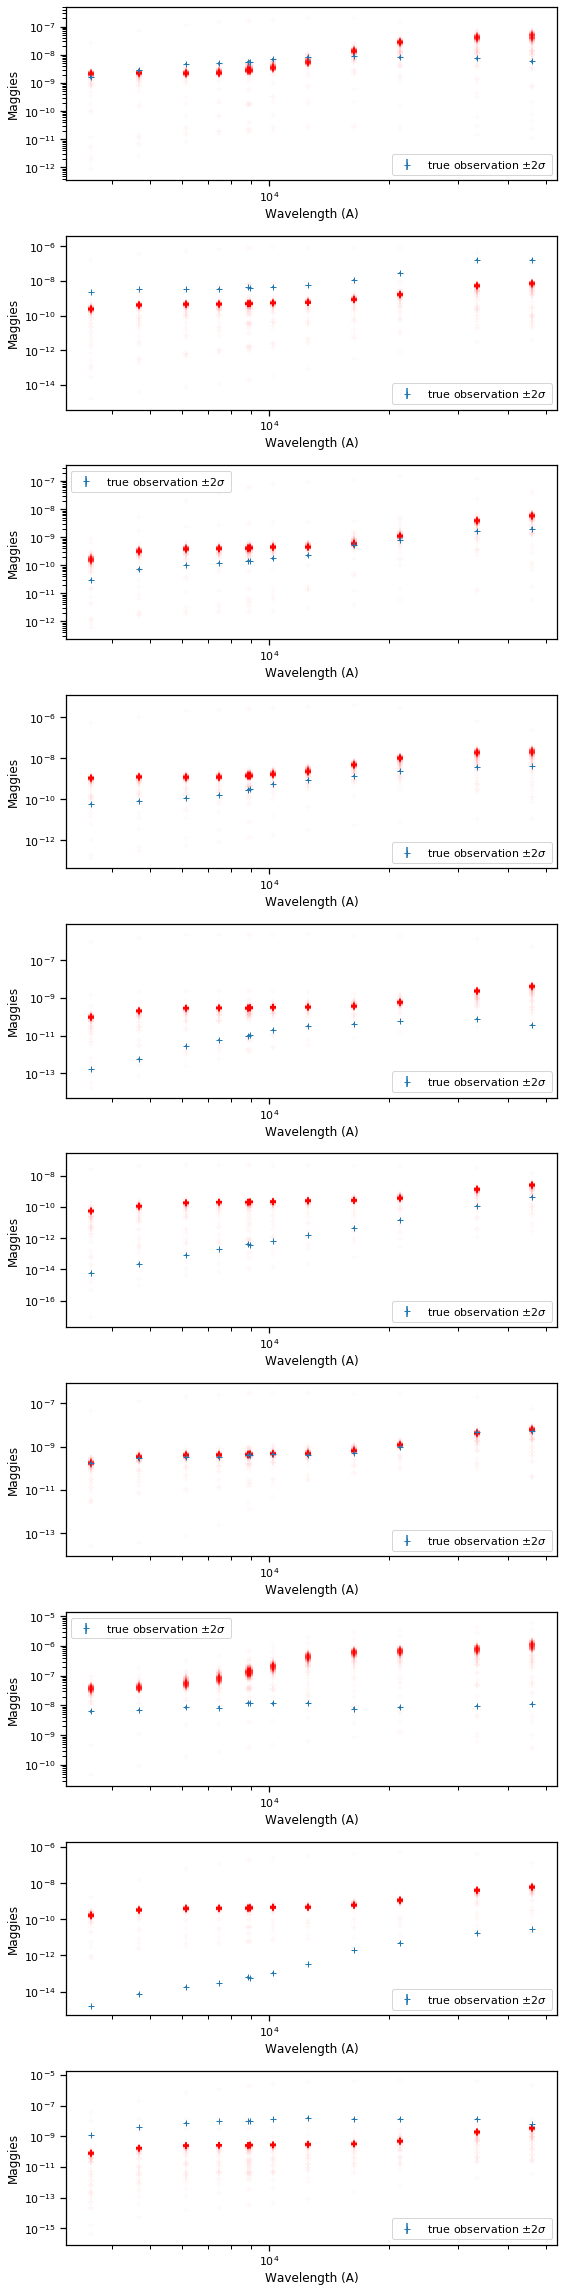

In [35]:
n_galaxies = 10

fig, axes = plt.subplots(nrows=n_galaxies, figsize=(8, 32))

n = 0
for galaxy in galaxies:
    ax = axes[n]
#     plot_galaxy(galaxy, ax, wavelengths)
    plot_galaxy_with_emulator(galaxy, ax, emulator, wavelengths)
    n += 1
    if n >= n_galaxies:
        break
plt.tight_layout()

In [25]:
galaxy['samples'].shape

(29713, 8)

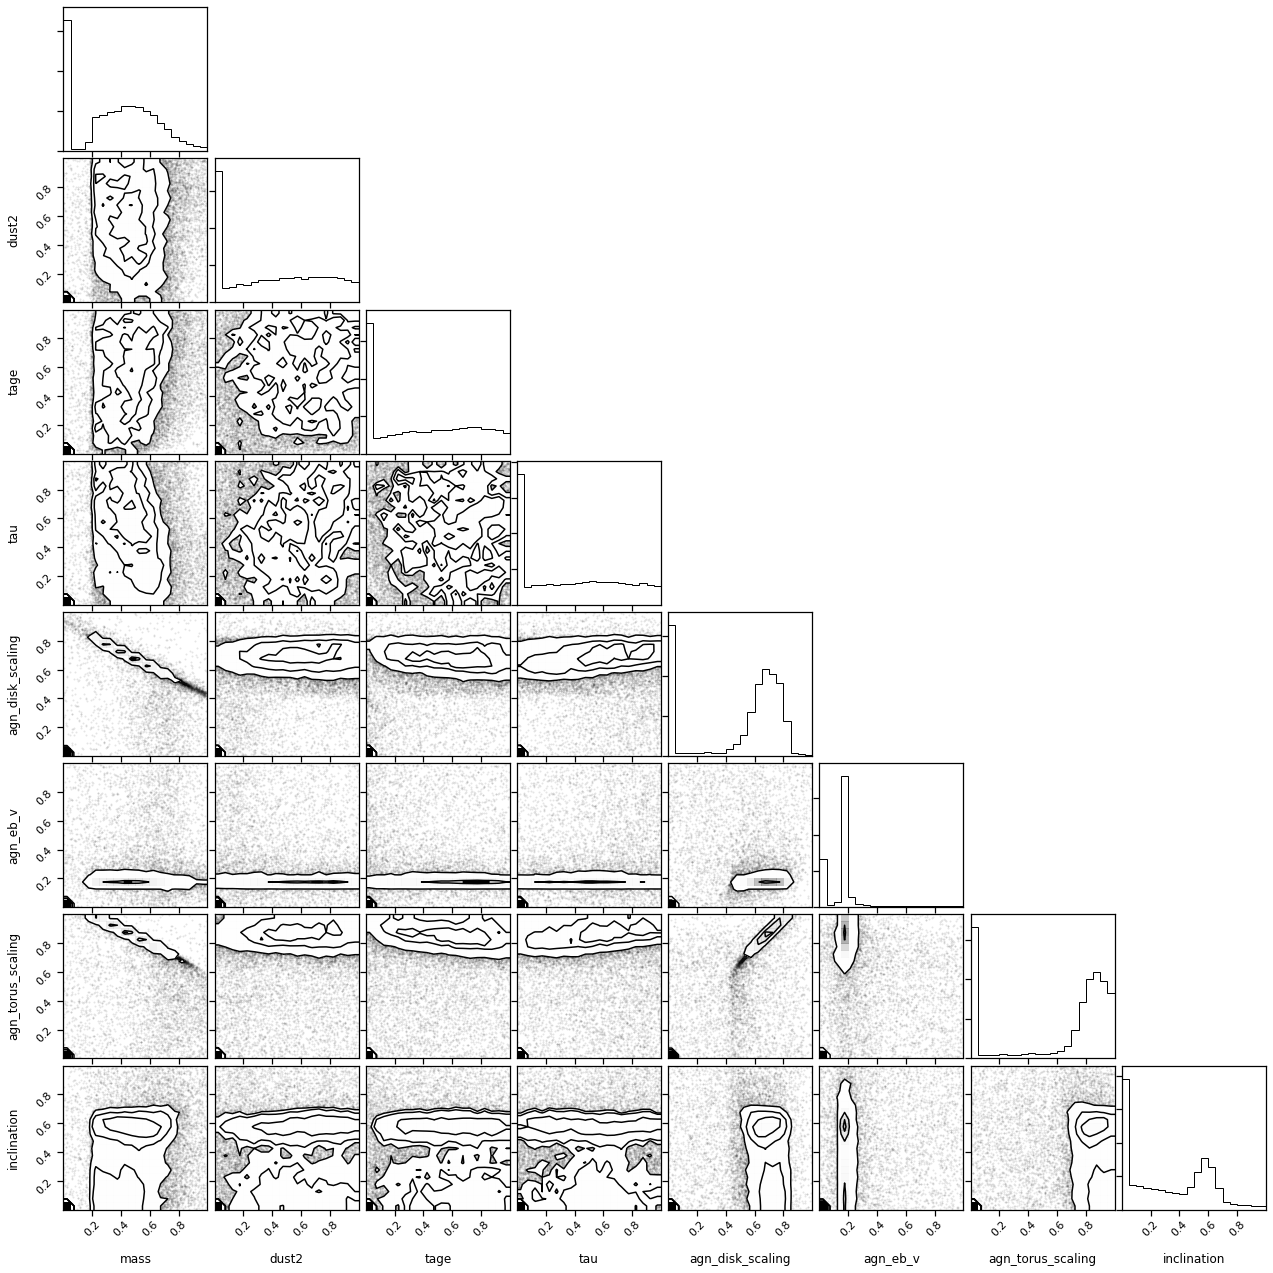

In [26]:
_ = corner.corner(galaxy['samples'], labels=params)